In [705]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Research Question
The intent of this analysis is to determine whether, through the application of techniques and methodologies central to the fields of data science and machine learning, a patient is likely to suffer a stroke based on a combination of variables (described in subsequent sections).

This exploration will consist of the following:  
* Loading the data  
* Data preprocessing  
* Exploratory data analysis (EDA)  
* Data partitioning  
* Building a machine learning classification model  
   - Random Forest  
   - Logistic Regression  
* Model Evaluation  
* Conclusion

The conclusion will assess the efficacy of predicting whether an individual will suffer a stroke or not based on a combination of input variables discussed in proceeding sections.

# Load the Data
https://www.kaggle.com/fedesoriano/stroke-prediction-dataset  
The dataset was sourced from Kaggle and consists of 5110 examples of patient data, each with 11 features + 1 binary indicator variable for whether the patient had suffered a stroke or not.

Of the variables, one is trivial, seven are categorical (all nominal), and three are numerical. The target variable, “stroke”, is a binary indicator as aforementioned.

In [706]:
strokedf = pd.read_csv("healthcare-dataset-stroke-data.csv")
strokedf.columns = [x.lower() for x in strokedf.columns]
strokedf.shape
strokedf.head()

(5110, 12)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [707]:
#Check for null values and return dtypes of each column
strokedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [708]:
#Print unique values in non-numeric columns
catcols = ['gender','hypertension','heart_disease','ever_married',
           'work_type','residence_type','smoking_status']

for col in catcols:
    print(col,":",stroke[col].unique())

gender : ['Male' 'Female' 'Other']
hypertension : [0 1]
heart_disease : [1 0]
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


From the unique values, we can see that no ordinality exists for any of the categorical variables. As such, we will one-hot encode these variables before building our model so that they may be used as inputs to our machine learning classifier.

# Data Preprocessing
The "id" column will be inconsequential to our analysis, so it will be dropped.  
From the .info() command, we can see that only the "bmi" column has missing variables (201 NaNs). Because we are building a classifier for something medically-sensitive, and because the number of missing values is less than 5% of the total number of values, we will exclude examples with missing values instead of interpolating so as to preserve the integrity of the data.

In [709]:
stroke = strokedf.drop(columns=["id"])
stroke.dropna(inplace=True)
stroke.reset_index(drop=True,inplace=True)
stroke.shape
stroke.head()

(4909, 11)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Next we convert categorical features to numerical using one-hot encoding (pd.get_dummies()).  
We also separate the features from the target into X and y, respectively.

In [710]:
X = pd.concat([stroke[["age","avg_glucose_level","bmi"]].copy(),pd.get_dummies(stroke[catcols])],axis=1)
y = stroke["stroke"]
X.shape
X.head()

(4909, 21)

,age,avg_glucose_level,bmi,hypertension,heart_disease,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
1,80.0,105.92,32.5,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
2,49.0,171.23,34.4,0,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
3,79.0,174.12,24.0,1,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,81.0,186.21,29.0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0


# Exploratory data analysis (EDA)
First we output some descriptive statistics of the continuous columns of the dataset using pandas.describe().

In [711]:
stroke[["age","avg_glucose_level","bmi"]].describe()

,age,avg_glucose_level,bmi
count,4909.000000,4909.000000,4909.000000
mean,42.865374,105.305150,28.893237
std,22.555115,44.424341,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.070000,23.500000
50%,44.000000,91.680000,28.100000
75%,60.000000,113.570000,33.100000
max,82.000000,271.740000,97.600000


Now we will evaluate any correlation between the features using a corrplot and associated heatmap.  
Note: it is only possible to visualize Pearson's R correlation due to the conversion of categorical features to numerical as conducted above.

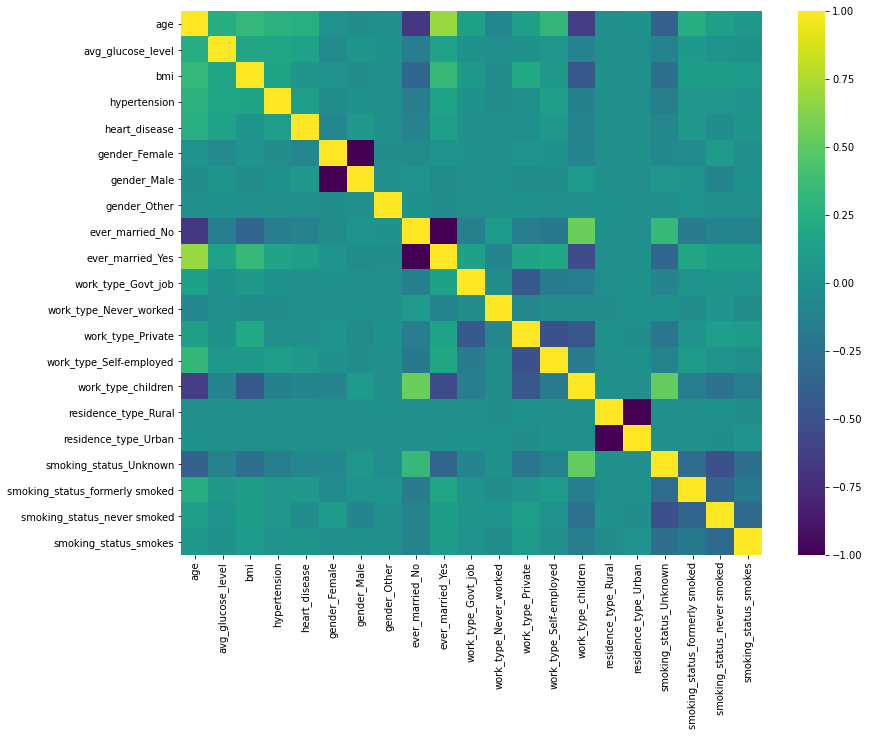

In [712]:
plt.figure(figsize=(13,10))
sns.heatmap(X.corr(method="pearson"),cmap="viridis");

The correlation heatmap does not indicate extreme unexpected correlation between the features outside of predictable correlations such as age and marriage/kids, age and bmi, or binary variables. Thus, the assumption of low multicollinearity necessary for logistic regression is met.

Random Forests are built on an ensemble of Decision Trees, which require no assumptions are met prior to model fitting, as they are based on binary splits of the input features.

Next we will explore the relationship between each of the feature variables and the target.  
For categorical variables, this will be accomplished with contingency tables.  
For continuous variables, this will be accomplished with a pairwise scatterplot.

In [713]:
pd.concat([pd.crosstab(stroke[catcols][x],stroke.stroke) for x in stroke[catcols]],keys=stroke[catcols])

stroke                             0    1
gender         Female           2777  120
               Male             1922   89
               Other               1    0
hypertension   0                4309  149
               1                 391   60
heart_disease  0                4497  169
               1                 203   40
ever_married   No               1682   23
               Yes              3018  186
work_type      Govt_job          602   28
               Never_worked       22    0
               Private          2684  127
               Self-employed     722   53
               children          670    1
residence_type Rural            2319  100
               Urban            2381  109
smoking_status Unknown          1454   29
               formerly smoked   780   57
               never smoked     1768   84
               smokes            698   39

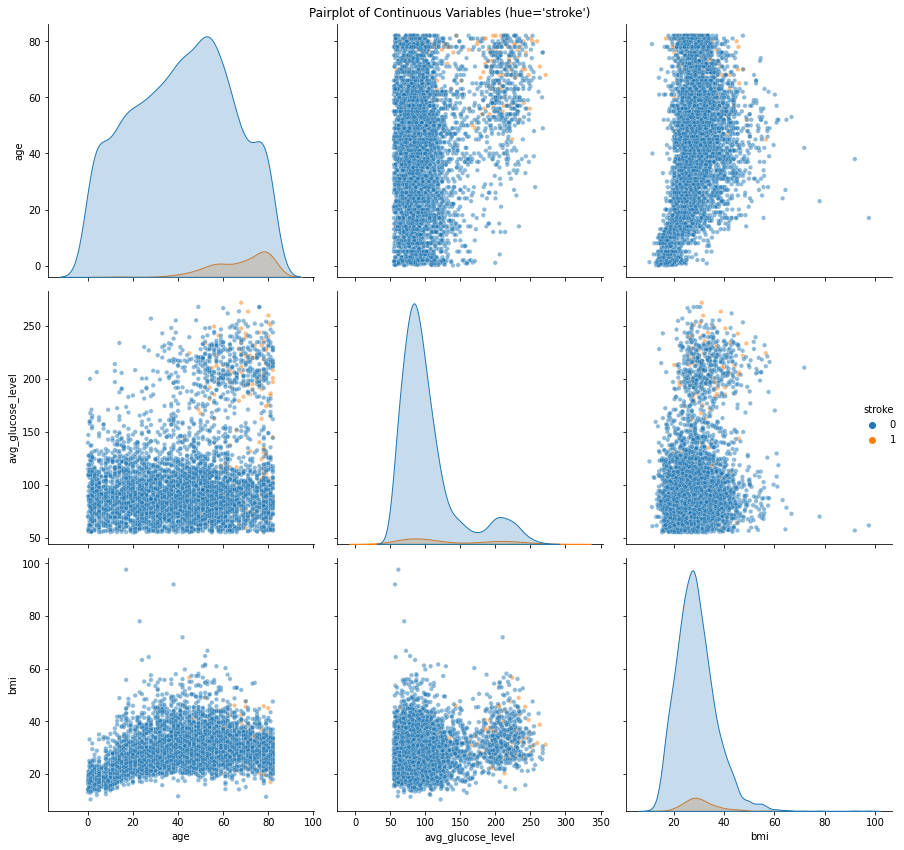

In [714]:
sns.pairplot(stroke[["age","avg_glucose_level","bmi","stroke"]],hue="stroke",
             height=4,aspect=1.0,plot_kws={"alpha":0.5,"s":20});
plt.suptitle("Pairplot of Continuous Variables (hue='stroke')");
plt.tight_layout();

From the above tables/plots, we notice a couple things:  
* Dataset is imbalanced, with stroke=1 examples being under-represented
* Some relationship exists between all of the variables and the target, with the weakest relationships belonging to the residence_type (almost no relationship with target) and bmi (based on the visualizations)
* Outliers exist within the both the avg_glucose_level and bmi features

To correct the first bullet point (imbalanced class distribution), we will oversample the training set before fitting to our models in order to allow the underlying algorithms to better pick up on feature patterns to allow for differentiation between the classes.

In addition, outliers would typically be corrected through a variety of correction methodologies (ie. replacing outliers with 1.5 times the IQR, removing them, etc.). In our case, the data will be preserved as we are dealing with actual patient data and any observable trends need to be based on an undoctored dataset. To complement this, feature scaling will be done through MinMaxScaler() in sklearn, which is robust to outliers within feature columns.

In [715]:
#Drop residence_type from features
X.drop(columns=['residence_type_Rural','residence_type_Urban'],inplace=True)

# Data partitioning
We will split the data along a 70/30 train/test ratio in order to build and evaluate our classification algorithms.

In [716]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3681, 19), (1228, 19), (3681,), (1228,))

Next, we will oversample the training set prior to fitting our models.  
The choice to oversample the minority class instead of undersampling the majority class was taken because even though oversampling could in some cases lead to overfitting, undersampling leads to loss of information. In our case, the problem from undersampling outweighs the problem from overfitting, as we are dealing with sensitive medical records.

For oversampling, we will use the imbalanced-learn library.  
https://imbalanced-learn.org/stable/over_sampling.html

In [717]:
print("X_train shape:")
print(X_train.shape)
print("\ny_train value counts:")
print(y_train.value_counts())

X_train shape:
(3681, 19)

y_train value counts:
0    3535
1     146
Name: stroke, dtype: int64


In [718]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=42)
X_train_over,y_train_over = oversample.fit_resample(X_train,y_train)

In [719]:
print("X_train_over shape:")
print(X_train_over.shape)
print("\ny_train_over value counts:")
print(y_train_over.value_counts())

X_train_over shape:
(7070, 19)

y_train_over value counts:
1    3535
0    3535
Name: stroke, dtype: int64


# Model Building
We are now ready to build our models on the processed and partitioned stroke data.  
For this analysis, we will explore Random Forest and Logistic Regression classification algorithms.

Random Forest:
* Non-parametrics (no assumptions about underlying distribution of the variables)
* Ensemble learning method (base = Decision Trees)

Logistic Regression:
* Parametric
* Learning method uses a logistic function (logit) to model a binary dependent variable based on probabilities

Because the class distribution within our test set is imbalanced, we will use F1 score instead of accuracy to evaluate our models.

In [720]:
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

Before fitting the data to the LogisticRegression classifier in sklearn, we must first scale continuous variables using MinMaxScaler() from sklearn. MinMaxScaler is robust to outliers (which do exist within our continuous features) and transforms the range of the data to within 0 and 1, which equalizes the variance with the one-hot encoded categorical variables.

Note: Though logistic regression differs from linear regression in that the continuous features do not need to have a normal distribution, scaling is still important in order to equalize feature importances to the output.

We will fit the scaler to our X_train_over data, then transform both X_train_over and X_test before fitting our model.

Note: Scaling is not required for RandomForestClassifier(), but doing so will not significantly affect the model performance one way or another.

In [721]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train_over)

X_train_scaled = pd.DataFrame(scaler.transform(X_train_over),columns=X_train_over.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

X_train_scaled.shape
X_train_scaled.head()

(7070, 19)

,age,avg_glucose_level,bmi,hypertension,heart_disease,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.377441,0.223571,0.114002,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.023438,0.035869,0.224287,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.731445,0.273382,0.235440,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.218750,0.248130,0.126394,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.658203,0.208522,0.234201,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Random Forest

In [722]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42).fit(X_train_scaled,y_train_over)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Training Set Confusion Matrix (counts):


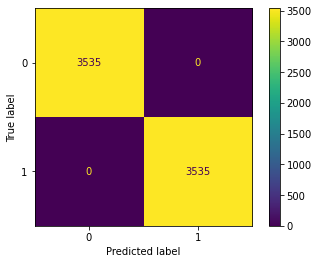

In [723]:
print("Training Set Confusion Matrix (counts):")
plot_confusion_matrix(rf,X_train_scaled,y_train_over);


Test Set Confusion Matrix (counts):


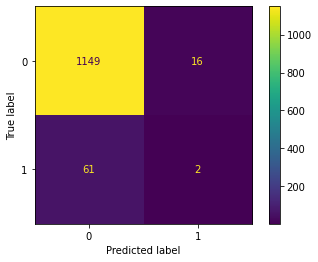

In [724]:
print("\nTest Set Confusion Matrix (counts):")
plot_confusion_matrix(rf,X_test_scaled,y_test);

In [725]:
print("Training F1 Score: ")
f1_score(rf.predict(X_train_scaled),y_train_over)
print("\nTest F1 Score: ")
f1_score(rf.predict(X_test_scaled),y_test)

Training F1 Score: 


1.0


Test F1 Score: 


0.04938271604938271

There are a number of hyperparameters that can be tuned when using a Random Forest classifier.  

Because this stage of the analysis is simply to fit the data to each classifier for the purposes of comparison, the default parameters were chosen. Based on the scores for both the training and test sets, we can immediately see that overfitting is occurring.

## Logistic Regression

In [726]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42,max_iter=300).fit(X_train_scaled,y_train_over)
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 300,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Training Set Confusion Matrix (counts):


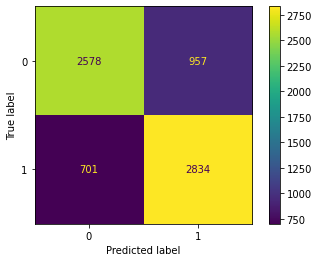

In [727]:
print("Training Set Confusion Matrix (counts):")
plot_confusion_matrix(lr,X_train_scaled,y_train_over);


Test Set Confusion Matrix (counts):


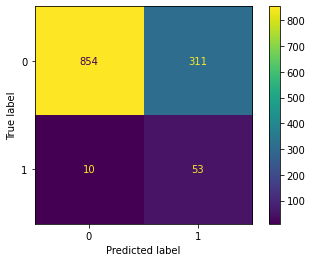

In [728]:
print("\nTest Set Confusion Matrix (counts):")
plot_confusion_matrix(lr,X_test_scaled,y_test);

In [729]:
print("Training F1 Score: ")
f1_score(lr.predict(X_train_scaled),y_train_over)
print("\nTest F1 Score: ")
f1_score(lr.predict(X_test_scaled),y_test)

Training F1 Score: 


0.7736827736827737


Test F1 Score: 


0.24824355971896958

The scores for logistic regression again indicate significant overfitting.  
However, the F1 score returned for logistic regression on the test data indicate that LR might be a more suitable model to use for classification of our specific dataset.

We will continue our analysis using this model.

## Model Evaluation

Now we tune the hyperparameters of our LogisticRegression() classifier using GridSearchCV.

There isn't much to tune as far as hyperparameters go for Logistic Regression; for this analysis we will explore different values of C as well as different algorithmic solvers. The "C" parameter is the inverse of the regularization term, and controls the shrinkage of feature coefficients for the specified penalty ("L1" in this case).

In [730]:
from sklearn.model_selection import GridSearchCV

params = {
    "C" : np.arange(0.1,1.1,0.1),
    "solver" : ["lbfgs","liblinear","sag","saga"]
}

lr_gs = GridSearchCV(lr,param_grid=params,cv=5).fit(X_train_scaled,y_train_over)

In [731]:
lr_final = lr_gs.best_estimator_
lr_final

LogisticRegression(C=0.1, max_iter=300, random_state=42, solver='liblinear')

Training Set Confusion Matrix (counts):


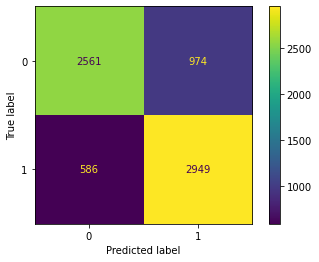

In [732]:
print("Training Set Confusion Matrix (counts):")
plot_confusion_matrix(lr_final,X_train_scaled,y_train_over);


Test Set Confusion Matrix (counts):


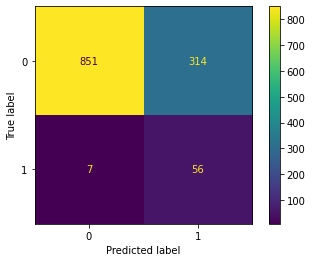

In [733]:
print("\nTest Set Confusion Matrix (counts):")
plot_confusion_matrix(lr_final,X_test_scaled,y_test);

In [734]:
print("Training F1 Score: ")
f1_score(lr_final.predict(X_train_scaled),y_train_over)
print("\nTest F1 Score: ")
f1_score(lr_final.predict(X_test_scaled),y_test)

Training F1 Score: 


0.7908286403861625


Test F1 Score: 


0.2586605080831409

# Conclusion

Hyperparameter tuning did increase the F1 score for both the training and test sets, somewhat, but the discrepancy between the two remains significant.  
This can be explained by the imbalanced class distribution within the test set.

Though the F1 score for the test set is indeed low, we can see from the confusion matrix that the final model correctly predicted 56 of 64 positive stroke patients based on the features, and correctly predicted 851 of 1165 negative stroke patients.

Typically, when dealing with medical data, false negatives are much costlier than false positives; our model has a much lower false negative rate than a false positive rate.

In [735]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test,lr_final.predict(X_test_scaled)).flatten()

In [736]:
print("False Positive Rate (Test):")
print(fp/(fp+tn))
print("\nFalse Negative Rate (Test):")
print(fn/(fn+tp))

False Positive Rate (Test):
0.26952789699570817

False Negative Rate (Test):
0.1111111111111111


We can now extract the feature importances of our model and display them in a bar chart.

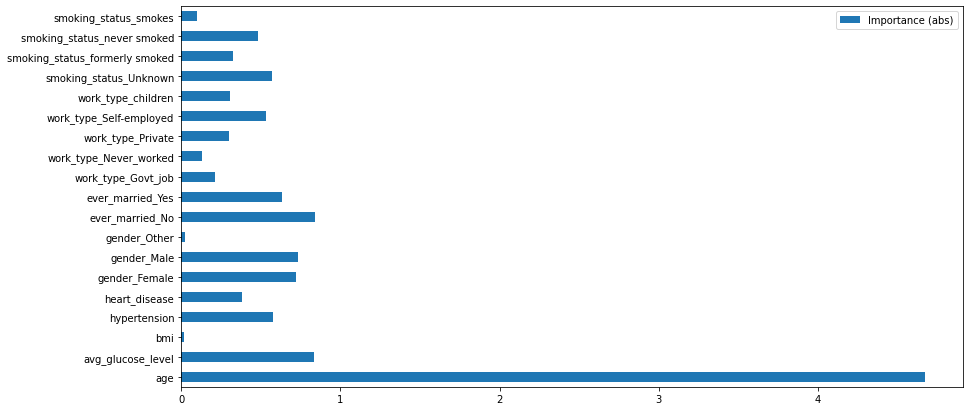

In [737]:
importances = pd.DataFrame(abs(lr_final.coef_[0]),index=X_test_scaled.columns,columns=["Importance (abs)"])
importances.plot(figsize=(14,7),kind="barh",sort_columns=True);

From the plot, a number of observations can be concluded.

Interestingly, BMI had very little effect on predicting strokes (according to the logistic regression model we fit). "gender_other" also, as expected, had little effect on the model, being that it was only represented in a single case in the original data.

We can see from the coefficients that avg_glucos_level, gender, hypertension, and marriage status were most influential for our classification algorithm.

## Further Analysis

Further analysis would most certainly include exploration of other classification algorithms, such as K-Nearest Neighbors (KNN), Support Vector Classifiers (SVC), and Naive Bayes implementations. In addition, models could be rerun after a primary analysis, with unimportant features dropped from the dataset.